In [2]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np
import torch
from src.model import get_model_and_optim
from src.data import prepare_nuclear_data
from src.utils import  PlottingContext, IO, get_rms
from sklearn.decomposition import PCA
from src.data import semi_empirical_mass_formula, BW2_mass_formula
import seaborn as sns
plt.style.use('mine')

In [3]:
import glob
locations = glob.glob('/export/d0/kitouni/data/experiments/long-runs/*')

keys = [l.split('/')[-1].split('-')[1] for l in locations]
def cleanup(name):
    if '+' in name: return 'all'
    while name[-1].isdigit() or name[-1] == '.':
        name = name[:-1]
    return name
keys = [cleanup(k) for k in keys]
locations = {key:l for key, l in zip(keys, locations)}
task_rms_values = {}

# Explorations

In [4]:
def inverse_transform(tensor, data):
    min_ = torch.from_numpy(data.regression_transformer.data_min_).to(tensor.device)
    max_ = torch.from_numpy(data.regression_transformer.data_max_).to(tensor.device)
    return tensor * (max_ - min_) + min_

def get_preds(X, model, data, batch = 200):
    preds = torch.zeros(X.shape[0], 1).to(X.device)
    with torch.no_grad():
        for i in range(0, X.shape[0], batch):
            preds_ = inverse_transform(model(X[i:i+batch]), data)
            preds_ = torch.gather(preds_, 1, X[i:i+batch, [2]])
            preds[i:i+batch] = preds_
    return preds

def get_rms(X, y, model, data):
    preds = get_preds(X, model, data)
    rms = {}
    for i, task_name in enumerate(data.output_map):
        task_mask = X[:, 2] == i
        rms[task_name] = torch.sqrt(torch.mean((preds[task_mask] - y[task_mask])**2)).item()
    return rms

## Embeddings

## Features

In [5]:
model_name = 'all'
location = locations[model_name]
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))

mask = data.train_mask & ~torch.isnan(data.y[:, 0])
X_train = data.X[mask]
y_train = data.y[mask]

Loading model from /export/d0/kitouni/data/experiments/long-runs/long_run-binding100+z1+n1+radius0.02+qa200+qbm200+qbm_n200+qec200+sn200+sp200-seed0/ckpts/model.pt


In [6]:
def get_penultimate_acts(model, X):
    # Save the last layer activations
    acts = torch.zeros(len(X), args.HIDDEN_DIM, device=args.DEV)
    # save the activations fed into the readout layer
    hook = model.readout.register_forward_pre_hook(
        lambda m, i: acts.copy_(i[0].detach())
    )
    model(X)
    hook.remove()
    return acts

def output_to_rms(output, data, X):
    preds = inverse_transform(output, data)
    preds = preds.gather(1, X[:, 2].long().view(-1, 1))
    return np.sqrt(np.mean((preds.detach().cpu().numpy() - y.detach().cpu().numpy()) ** 2))
    

X = data.X
y = data.y
mask = lambda x: x[(X[:, 2] == 0) & ~torch.isnan(y.view(-1))]
X, y = mask(X), mask(y)

acts = get_penultimate_acts(model, X)
rms = output_to_rms(model.readout(acts), data, X)
print(f"RMS of readout layer: {rms:.2f}")

RMS of readout layer: 270.09


In [7]:
# linear regression from activations to output to compare with the readout layer
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(acts.detach().cpu().numpy(), y.detach().cpu().numpy())
lr_preds = reg.predict(acts.detach().cpu().numpy())
rms = np.sqrt(np.mean((lr_preds - y.detach().cpu().numpy()) ** 2))
print(f"RMS of linear regression: {rms:.2f}")

RMS of linear regression: 19.13


How is the linear regression prediction so much better?

In [8]:
model_norm = np.linalg.norm(model.readout.weight[0].detach().numpy())
lin_reg_norm = np.linalg.norm(reg.coef_)
print(f"Norm of readout layer: {model_norm:.2f}, norm of linear regression weights: {lin_reg_norm:.2f}")

Norm of readout layer: 3.30, norm of linear regression weights: 881559.06


In [9]:
n_components = 100
pca = PCA(n_components=n_components)
weights = model.readout.weight.detach().cpu().numpy()[[0]]
weights = np.ones_like(weights)
# acts_pca = pca.fit_transform(acts.cpu().numpy())
acts_pca = pca.fit_transform(acts * weights)

# project to first n components
ns = np.arange(1, n_components+1)
rms_by_n, rms_ling_alg_by_n = {}, {}
for n in ns:
    acts_pca_ = np.zeros_like(acts_pca)
    acts_pca_[:, :n] = acts_pca[:, :n].copy()
    acts_ = pca.inverse_transform(acts_pca_) / weights
    acts_ = torch.tensor(acts_, device=args.DEV, dtype=torch.float32)
    rms = output_to_rms(model.readout(acts_), data, X)
    # lin regression rms:
    lr_preds = reg.predict(acts_)
    rms_ling_alg = np.sqrt(np.mean((lr_preds - y.detach().cpu().numpy()) ** 2))
    rms_by_n[n] = rms
    rms_ling_alg_by_n[n] = rms_ling_alg
rms_full_model = output_to_rms(model(X), data, X)

In [10]:
# compute z pca rmses
from tqdm import tqdm

z_pca_rmses = {}
z_emb = model.emb[0]
z_emb_pca = pca.fit_transform(z_emb.detach().cpu().numpy())
for n in tqdm(ns):
    z_emb_pca_ = np.zeros_like(z_emb_pca)
    z_emb_pca_[:, :n] = z_emb_pca[:, :n].copy()
    z_emb_ = pca.inverse_transform(z_emb_pca_)
    z_emb_ = torch.tensor(z_emb_, device=args.DEV, dtype=torch.float32)
    x = model.embed_input(X, [z_emb_, model.emb[1], model.emb[2]])
    x = model.nonlinear(x)
    rms = output_to_rms(model.readout(x), data, X)
    z_pca_rmses[n] = rms

n_pca_rmses = {}
n_emb = model.emb[1]
n_emb_pca = pca.fit_transform(n_emb.detach().cpu().numpy())
for n in tqdm(ns):
    n_emb_pca_ = np.zeros_like(n_emb_pca)
    n_emb_pca_[:, :n] = n_emb_pca[:, :n].copy()
    n_emb_ = pca.inverse_transform(n_emb_pca_)
    n_emb_ = torch.tensor(n_emb_, device=args.DEV, dtype=torch.float32)
    x = model.embed_input(X, [model.emb[0], n_emb_, model.emb[2]])
    x = model.nonlinear(x)
    rms = output_to_rms(model.readout(x), data, X)
    n_pca_rmses[n] = rms


100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


In [11]:
rms_full_model = (model(X) - y).pow(2).mean().sqrt().item()

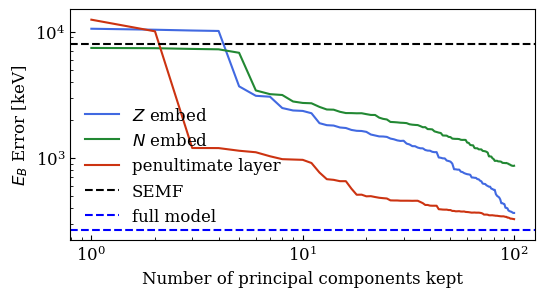

In [18]:
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(ns, z_pca_rmses.values(), label='$Z$ embed')
plt.plot(ns, n_pca_rmses.values(), label='$N$ embed')
plt.plot(ns, rms_by_n.values(), label='penultimate layer')
plt.axhline(7928.02400004463, label='SEMF', c='k', ls='--')
plt.axhline(rms_full_model, label='full model', c='b', ls='--')
# plt.plot(ns, rms_ling_alg_by_n.values(), label='linear regression')
plt.xlabel("Number of principal components kept")
plt.ylabel(r"$E_B$" + " Error [keV]")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig("plots/paper/figures/pca_err.pdf", bbox_inches='tight')

In [12]:
acts_pca = pca.fit_transform(acts.cpu().numpy() * weights)
# acts_pca = pca.fit_transform(acts.cpu().numpy())
features = []
for idx_phs_term in range(20):
    acts_pca_ = np.zeros_like(acts_pca)
    # set everything to zero except the ith component
    acts_pca_[:, idx_phs_term] = acts_pca[:, idx_phs_term]
    acts_ = pca.inverse_transform(acts_pca_)/ weights
    acts_ = torch.tensor(acts_, device=args.DEV)
    # comment out below to not rescale by readout layer
    # feat = reg.predict(acts_)
    feat = model.readout(acts_).detach().cpu().numpy()[:, [0]]
    features.append(feat)
features = np.hstack(features)

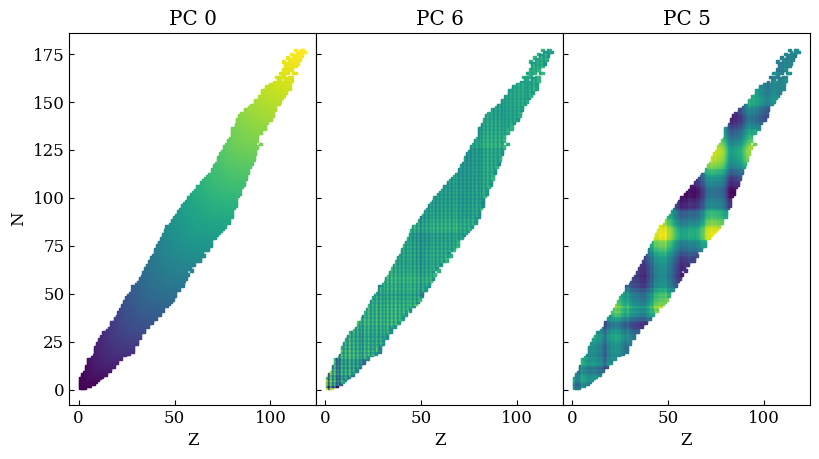

In [23]:
Z, N = X[:, :2].detach().cpu().numpy().T
pcs_to_plot = [0, 6, 5]
fig, axes = plt.subplots(1, 3, figsize=(8, 8), sharex=True, sharey=True)
for idx_phs_term, pc_idx in enumerate(pcs_to_plot):
    ax = axes[idx_phs_term]
    plt.sca(ax)
    plt.scatter(Z, N, c=features[:, pc_idx], cmap="viridis", s=4, marker="s", rasterized=True)
    ax.set_aspect('equal')
    if idx_phs_term // 3 == 0:
        plt.xlabel("Z")
    if idx_phs_term % 3 == 0:
        plt.ylabel("N")

    plt.title(f"PC {pc_idx}")
    # plt.title(f"PC {idx_phs_term} Cumm. RMS: {rms_by_n[idx_phs_term+1]:.2f}")
    # format color bar {.2f}
    # plt.colorbar(format='%.3f', )
fig.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.savefig(f"plots/long-runs/{model_name}/nice-pca-features.pdf", bbox_inches='tight')
plt.show()

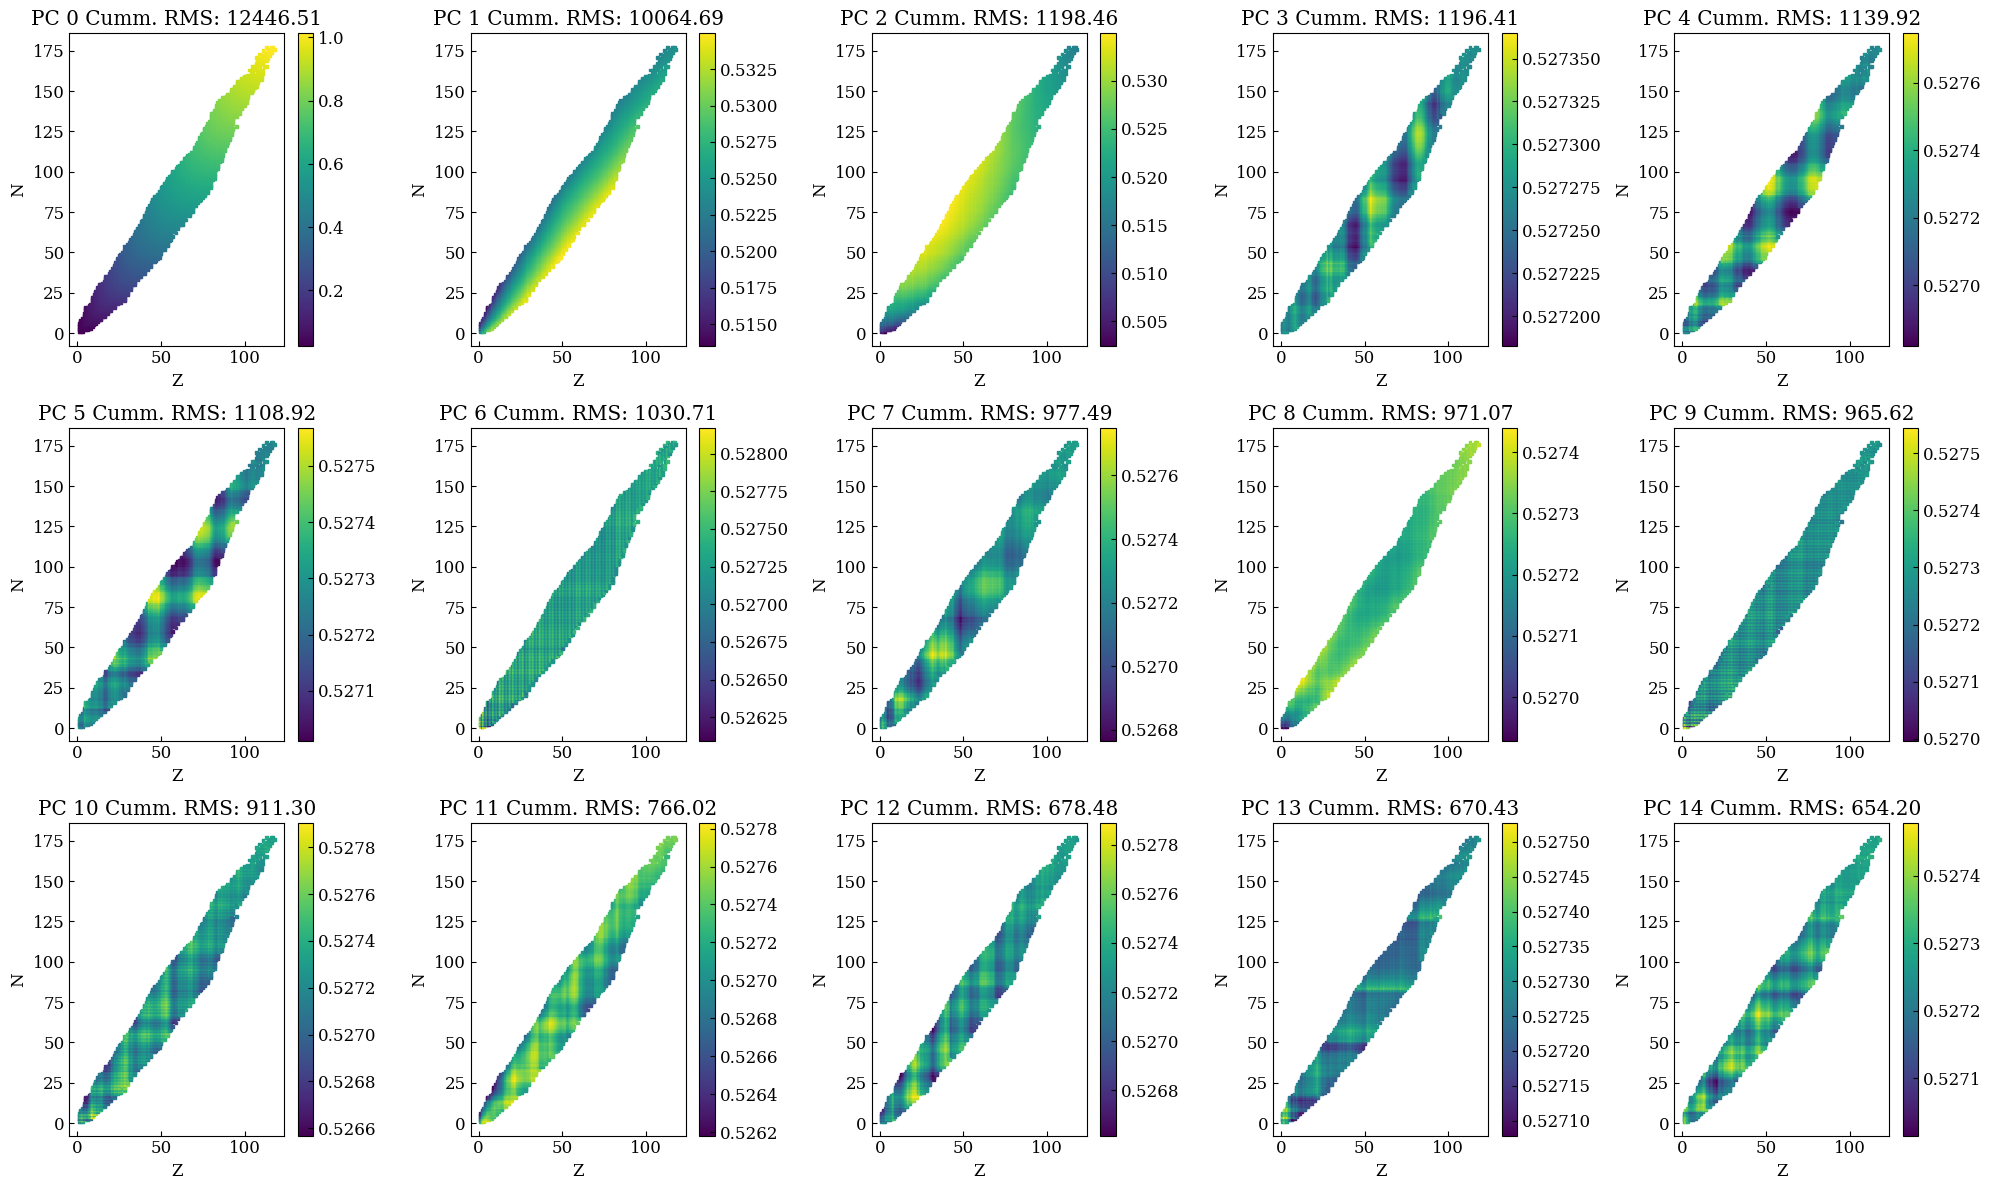

In [15]:
Z, N = X[:, :2].detach().cpu().numpy().T

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for idx_phs_term in range(len(axes.flatten())):
    ax = axes[idx_phs_term//5, idx_phs_term%5]
    plt.sca(ax)
    plt.scatter(Z, N, c=features[:, idx_phs_term], cmap="viridis", s=4, marker="s", rasterized=True)
    plt.xlabel("Z")
    plt.ylabel("N")
    # plt.title(f"PC {idx_phs_term}")
    plt.title(f"PC {idx_phs_term} Cumm. RMS: {rms_by_n[idx_phs_term+1]:.2f}")
    plt.colorbar()
fig.tight_layout()
fig.savefig(f"plots/long-runs/{model_name}/PCA-features.pdf")
plt.show()

# Paper plots

In [17]:
from src.utils import Physics
physics_terms = {func: getattr(Physics, func)(Z, N) for func in Physics.all_funcs}

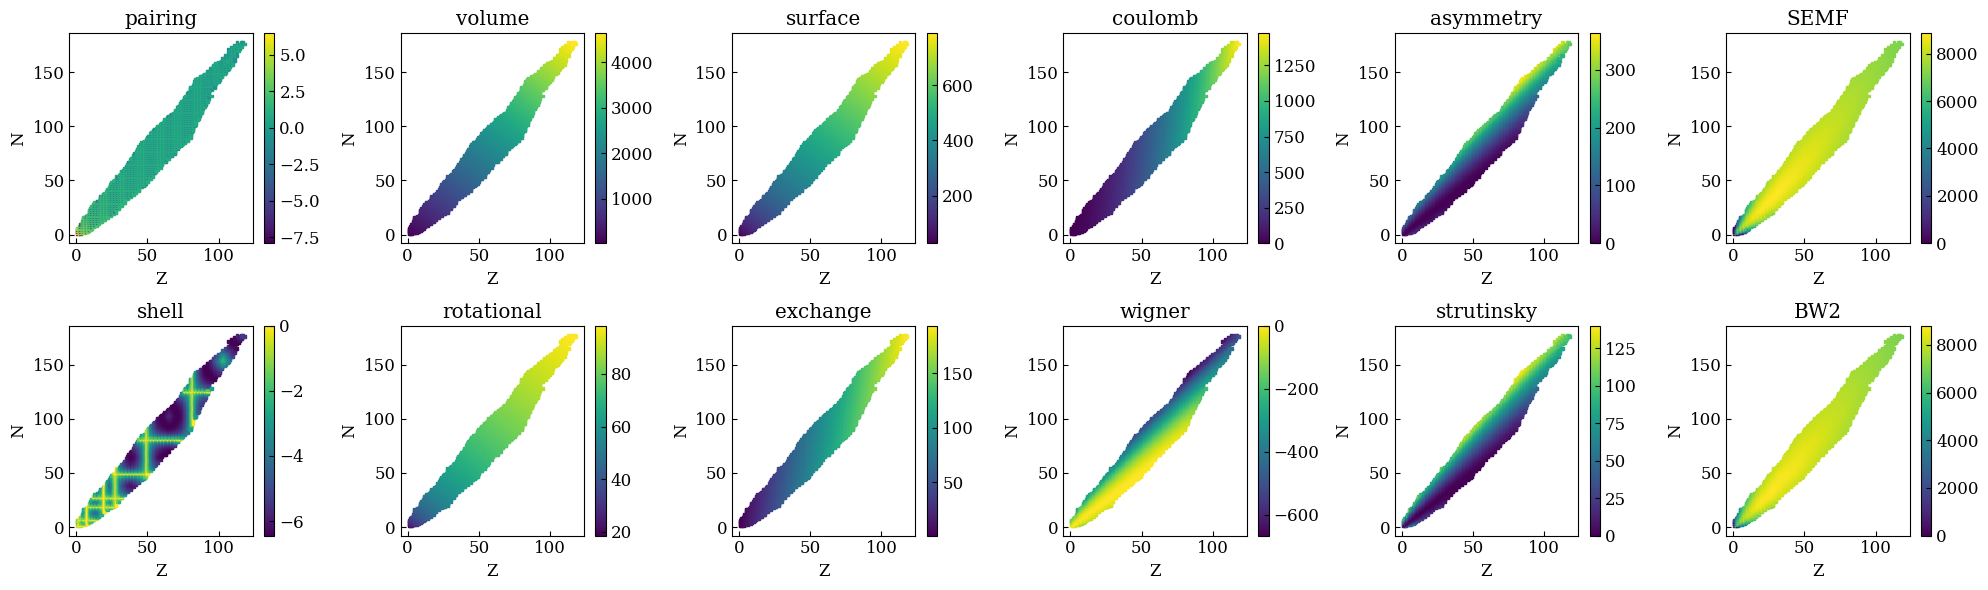

In [18]:
fig, axes = plt.subplots(2, 6, figsize=(20, 6))
for ax, func in zip(axes.flatten(), physics_terms):
    plt.sca(ax)
    plt.scatter(Z, N, c=physics_terms[func], cmap="viridis", s=4, marker="s", rasterized=True)
    plt.xlabel("Z"); plt.ylabel("N"); plt.title(func); plt.colorbar()
fig.tight_layout()
fig.savefig(f"plots/long-runs/{model_name}/physics-features.pdf")

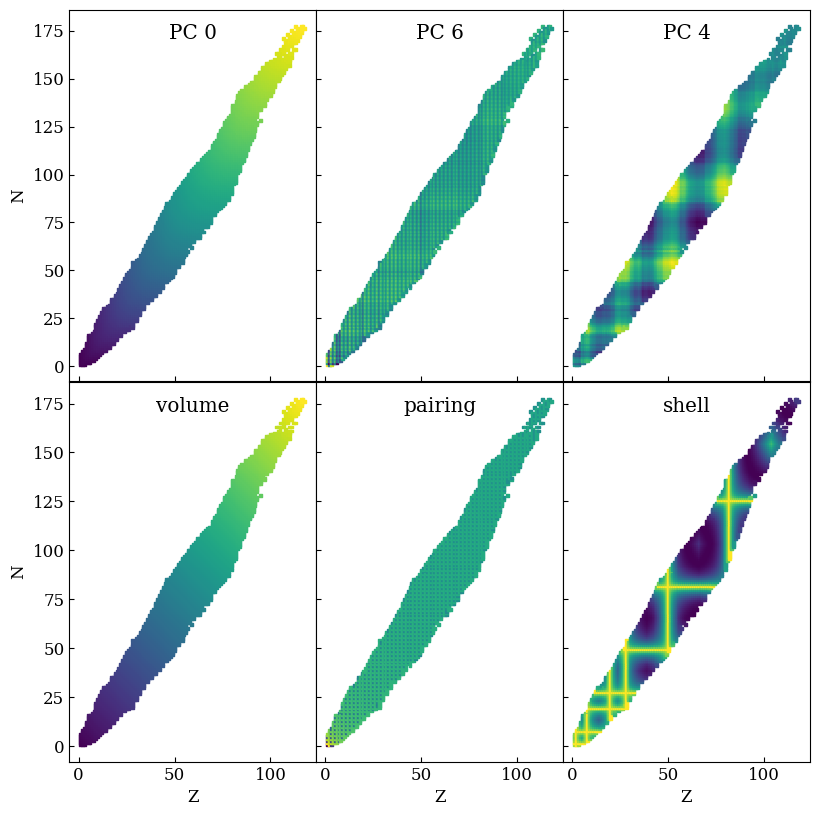

In [58]:
# let's remake nice-pca-features but with physics_terms in the second row of the plot
Z, N = X[:, :2].detach().cpu().numpy().T
pcs_to_plot = [0, 6, 4]
phs_terms = ["volume", "pairing", "shell"]
fig, axes = plt.subplots(2, 3, figsize=(8, 8), sharex=True, sharey=True)
for idx_phs_term, pc_idx in enumerate(pcs_to_plot):
    ax = axes[0, idx_phs_term]
    plt.sca(ax)
    plt.scatter(Z, N, c=features[:, pc_idx], cmap="viridis", s=4, marker="s", rasterized=True)
    ax.set_aspect('equal')
    ax = axes[1,idx_phs_term]
    plt.sca(ax)
    plt.scatter(Z, N, c=physics_terms[phs_terms[idx_phs_term]], cmap="viridis", s=4, marker="s", rasterized=True)
    
    axes[1, idx_phs_term].set_xlabel("Z")
    if idx_phs_term % 3 == 0:
        axes[0, idx_phs_term].set_ylabel("N")
        axes[1, idx_phs_term].set_ylabel("N")

    axes[0, idx_phs_term].set_title(f"PC {pc_idx}", y=0.9)
    axes[1, idx_phs_term].set_title(phs_terms[idx_phs_term], y=0.9)
    # plt.title(f"PC {idx_phs_term} Cumm. RMS: {rms_by_n[idx_phs_term+1]:.2f}")
    # format color bar {.2f}
    # plt.colorbar(format='%.3f', )
fig.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.savefig(f"plots/long-runs/{model_name}/nice-pca-features2.pdf", bbox_inches='tight')
plt.show()

/work/submit/kitouni/miniconda3/envs/sandbox/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


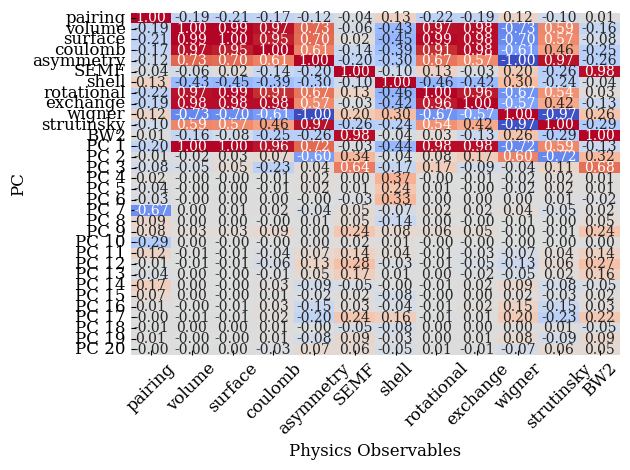

In [19]:
STAND = False
# cosine sim between terms
nn_features = features.T #/ (N+Z)
# nn_features = acts.cpu().detach().numpy().T[:30]
physics_features = np.stack(physics_terms.values()) # * (N+Z)
# standardize
standard = lambda x: (x - x.mean(1, keepdims=True))/x.std(1, keepdims=True)
if STAND:
    nn_features = standard(nn_features)
    physics_features = standard(physics_features)

R = np.corrcoef(physics_features, nn_features, rowvar=True) # compute var across rows

corr_mat = R[:physics_features.shape[0], -nn_features.shape[0]:]


corr_mat_long = R[:physics_features.shape[0]]
y_ticks = list(physics_terms.keys()) + [f"PC {i}" for i in range(1, nn_features.shape[0]+1)]
# plot
fig, ax = plt.subplots()
# sns.heatmap(corr_mat.T, ax=ax, cmap='coolwarm', annot=True, fmt='.2f', cbar=False)
sns.heatmap(corr_mat_long.T, ax=ax, cmap='coolwarm', annot=True, fmt='.2f', cbar=False); ax.set_yticks(np.arange(len(y_ticks))+0.5, labels=y_ticks, rotation=0)
ax.set_xticklabels(Physics.all_funcs, rotation=45)
ax.set_xlabel("Physics Observables")
ax.set_ylabel("PC")
plt.tight_layout()

# plt.savefig(f"plots/paper/{model_name}_correlation_matrix.pdf")

Text(52.58333333333333, 0.5, 'PC')

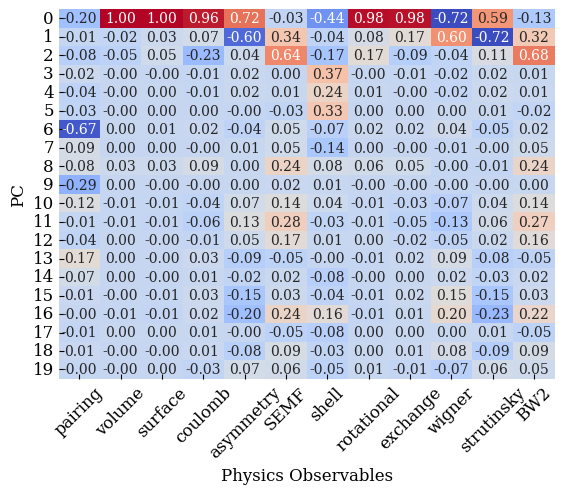

In [20]:
from scipy.stats import kendalltau
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_regression

def get_correlations(physics_features, nn_features, corr_func):
    corr_mat = np.zeros((physics_features.shape[0], nn_features.shape[0]))
    for i in range(physics_features.shape[0]):
        for j in range(nn_features.shape[0]):
            if corr_func == mutual_info_regression:
                corr_mat[i, j] = corr_func(nn_features[j].reshape(-1, 1), physics_features[i]).item()
            else:
                corr_mat[i, j] = corr_func(physics_features[i], nn_features[j]).correlation
    return corr_mat

corr_mat = get_correlations(physics_features, nn_features, pearsonr)
# imshow the correlation matrix
fig, ax = plt.subplots()
sns.heatmap(corr_mat.T, ax=ax, cmap='coolwarm', annot=True, fmt='.2f', cbar=False)
ax.set_xticklabels(Physics.all_funcs, rotation=45)
ax.set_xlabel("Physics Observables")
ax.set_ylabel("PC")


In [21]:
# # save pca features
znf = np.column_stack([Z, N, nn_features.T]).T
np.save(f"plots/long-runs/{model_name}/ZN_features.npy", znf)
znf = np.load(f"plots/long-runs/{model_name}/ZN_features.npy")
Z, N, nn_features = znf[0], znf[1], znf[2:]

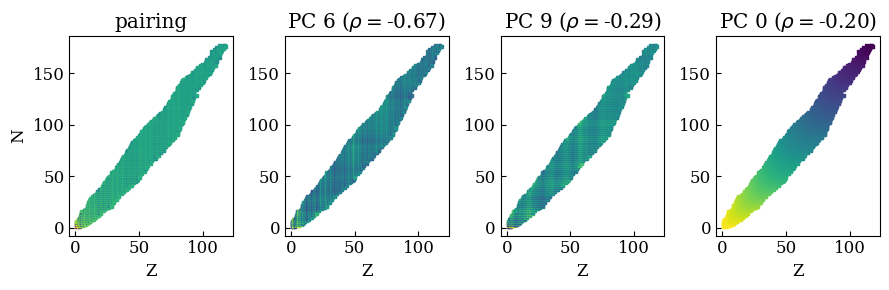

In [22]:
# obtain the topk highest PCs for each physcis term
topk = 3
topk_idxs = np.argsort(np.abs(corr_mat), axis=1)[:, -topk:][:, ::-1]
# get the corresponding values
topk_vals = corr_mat[np.arange(corr_mat.shape[0])[:, None], topk_idxs]
# get the corresponding nn features
topk_nn = nn_features[topk_idxs, :]
# plot
for idx_phs_term, term in enumerate(physics_terms):
    fig, axes = plt.subplots(1, topk+1, figsize=(3*topk, 3))
    plt.sca(axes[0]); plt.scatter(Z, N, c=physics_terms[term], cmap="viridis", s=4, marker="s"); plt.title(term); plt.xlabel("Z"); plt.ylabel("N")
    for idx_selected_match, ax in enumerate(axes.flatten()[1:]):
        plt.sca(ax)
        corr = topk_vals[idx_phs_term, idx_selected_match]
        plt.scatter(Z, N, c=topk_nn[idx_phs_term, idx_selected_match]*np.sign(corr), cmap="viridis", s=4, marker="s")
        plt.xlabel("Z"); plt.title(f"PC {topk_idxs[idx_phs_term, idx_selected_match]} "r"($\rho=$"f"{corr:.2f})")
        # plt.colorbar()
    fig.tight_layout()
    plt.show()
    break


## Matches Plot

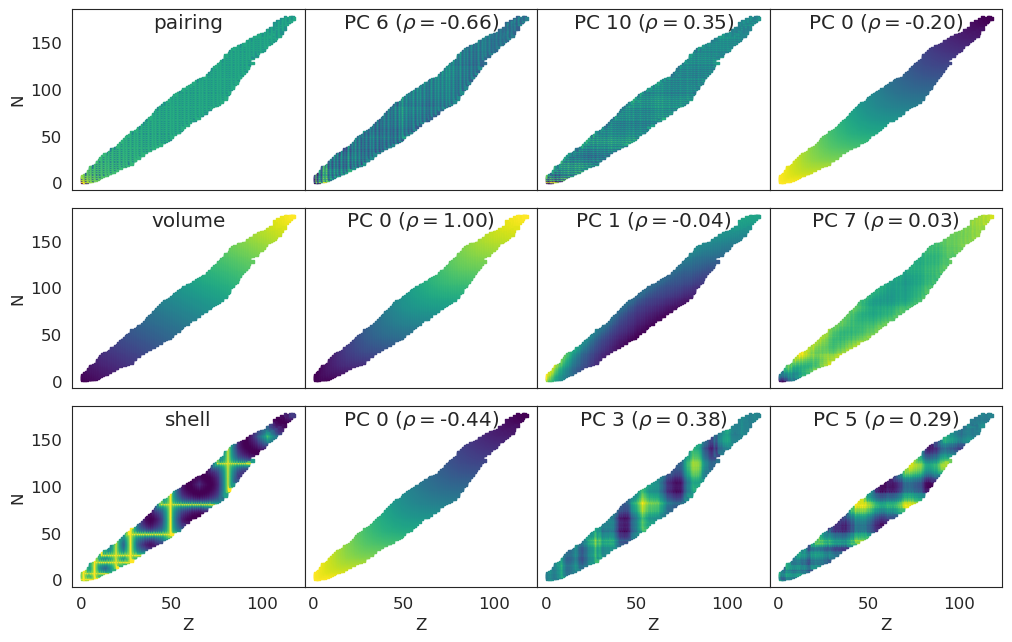

In [22]:
# let's pick pairing, volume, and shell terms to plot
sns.set_style('white')
cmap = "viridis"
terms = ["pairing", "volume", "shell"]
fig, axes = plt.subplots(len(terms), topk+1, figsize=(4*topk, 2.5*len(terms)), sharex=True, sharey=True)
for idx_phs_term, term in enumerate(physics_terms):
    if term not in terms: continue
    ax_idx = terms.index(term)
    plt.sca(axes[ax_idx, 0]); plt.scatter(Z, N, c=physics_terms[term], cmap=cmap, s=4, marker="s", rasterized=True); plt.title(term, y=0.85); plt.ylabel("N")
    for idx_selected_match, ax in enumerate(axes[ax_idx, 1:]):
        plt.sca(ax)
        corr = topk_vals[idx_phs_term, idx_selected_match]
        plt.scatter(Z, N, c=topk_nn[idx_phs_term, idx_selected_match]*np.sign(corr), cmap=cmap, s=4, marker="s", rasterized=True)
        plt.title(f"PC {topk_idxs[idx_phs_term, idx_selected_match]} "r"($\rho=$"f"{corr:.2f})", y=0.85)
for ax in axes[-1]: ax.set_xlabel("Z")
# fig.tight_layout(h_pad=0, w_pad=0.1)

for ax in axes[:,0]:
    ax.set_position([0.05, 0.1, 0.3, 0.8]) 

for ax in axes[:,1]:
    ax.set_position([0.35, 0.1, 0.3, 0.8])

for ax in axes[:,2]:
    ax.set_position([0.65, 0.1, 0.3, 0.8])
fig.subplots_adjust(wspace=0, hspace=0.1) 
plt.savefig(f"plots/long-runs/{model_name}/matches_last_layer.pdf")

/tmp/ipykernel_3715017/1786888138.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Z_emb[:, x_pc], Z_emb[:, y_pc], c=Z, cmap=cmap, s=0)


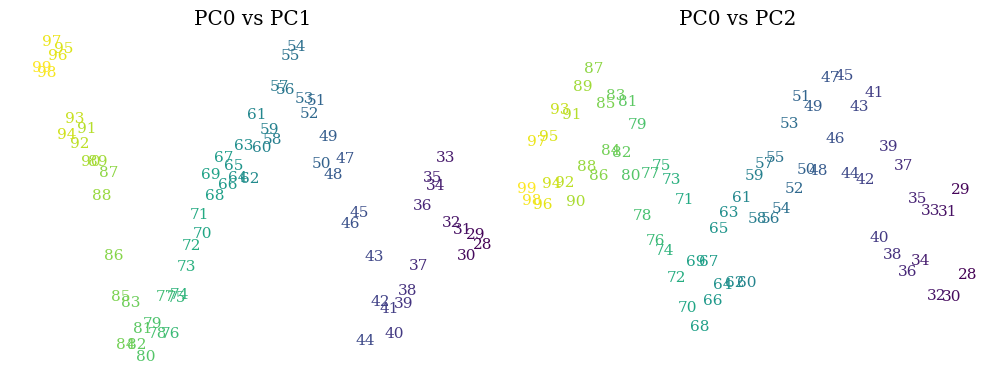

In [43]:
import matplotlib as mpl
Z_emb = model.emb[1].detach().cpu().numpy()
Z_emb = pca.fit_transform(Z_emb)
cmap = "viridis"
# plot the embeddings Z and N are the columns
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
# PC1 vs PC0
def plot_ax0(Z_emb, ax, x_pc=0, y_pc=1, title="Z"):
    Z = np.arange(len(Z_emb))
    Z = Z[28:100]
    labels = Z
    Z_emb = Z_emb[28:100]

    norm = mpl.colors.Normalize(vmin=min(Z), vmax=max(Z))
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    Z = sm.to_rgba(Z)

    plt.sca(ax)
    plt.scatter(Z_emb[:, x_pc], Z_emb[:, y_pc], c=Z, cmap=cmap, s=0)
    PlottingContext.scatter_text(labels, Z_emb[:, x_pc], Z_emb[:, y_pc], colors=Z, ax=plt.gca(), fontsize=11)
    plt.xlabel("PC0"); plt.ylabel("PC1"); plt.title(title)

for i, ax in enumerate(axes.flatten(),1):
    plot_ax0(Z_emb, ax, title=f"PC0 vs PC{i}", y_pc=i)
    plt.sca(ax)
    plt.axis('off')

plt.tight_layout()
# PC1 vs PC0
fig.tight_layout(w_pad=0, h_pad=0)
plt.savefig(f"plots/paper/figures/rich-struct.pdf")


## Embeddings Plot

Loading model from /export/d0/kitouni/data/experiments/long-runs/long_run-binding100+z1+n1+radius0.02+qa200+qbm200+qbm_n200+qec200+sn200+sp200-seed0/ckpts/model.pt


/tmp/ipykernel_3504531/1755530291.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Z_emb[:, x_pc], Z_emb[:, y_pc], c=Z, cmap=cmap, s=4)


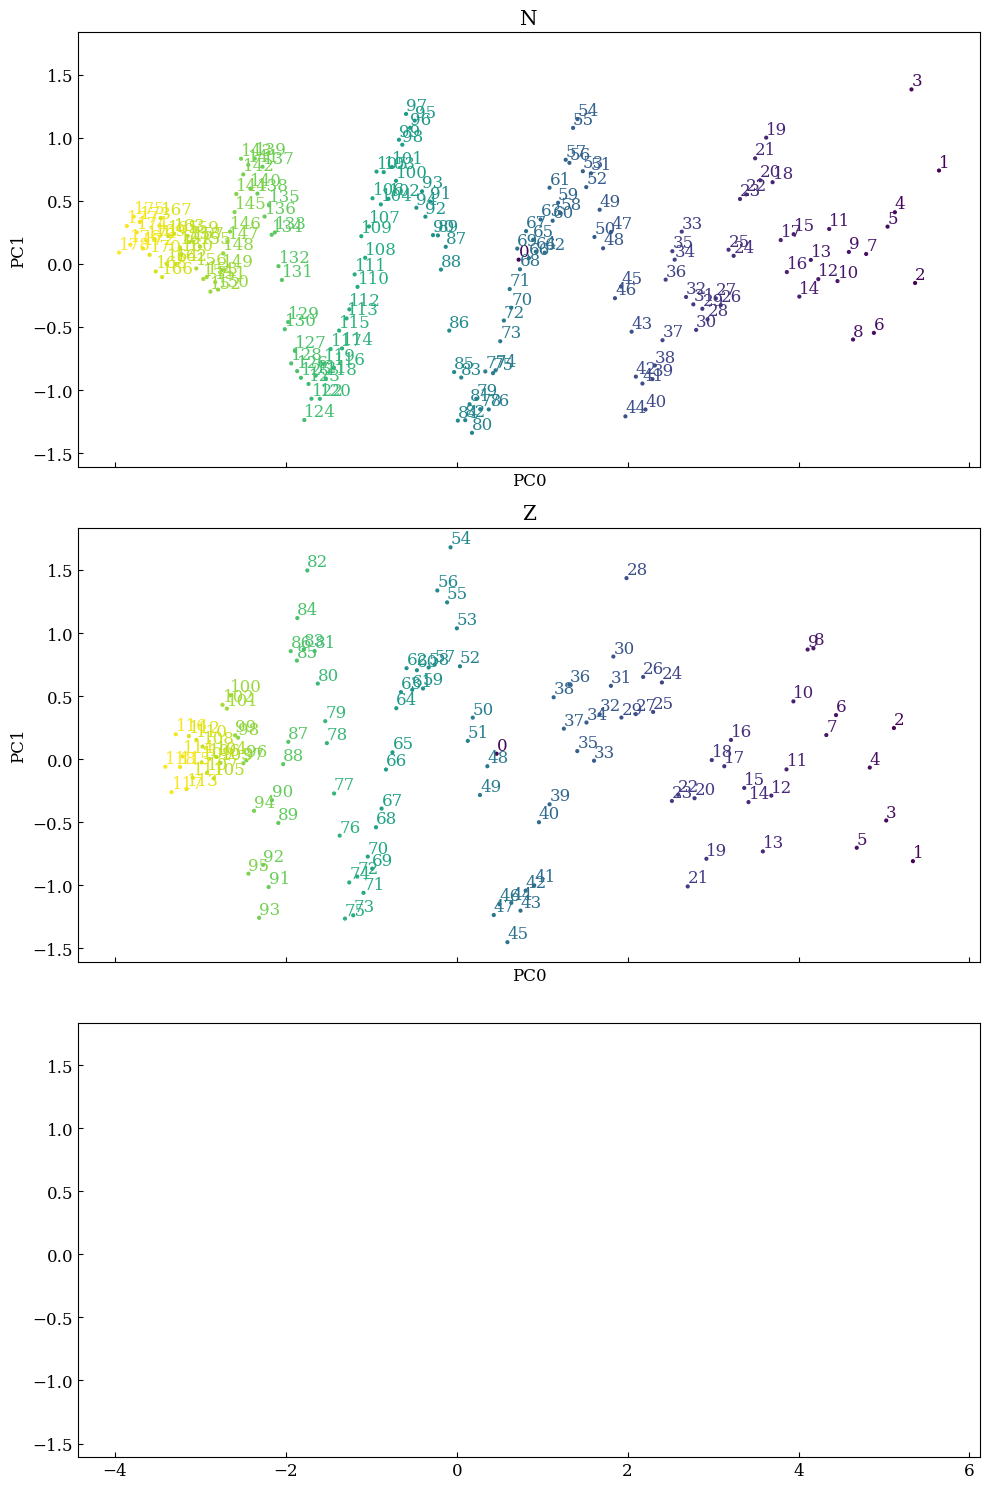

In [46]:
model_name = 'all'
location = locations[model_name]
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))

mask = data.train_mask & ~torch.isnan(data.y[:, 0])
X_train = data.X[mask]
y_train = data.y[mask]


import matplotlib as mpl
cmap = "viridis"

def get_embs(emb):
    emb = PCA(n_components=5).fit_transform(emb)
    Z = np.arange(len(emb))
    norm = mpl.colors.Normalize(vmin=min(Z), vmax=max(Z))
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    Z = sm.to_rgba(Z)
    return emb, Z

Z_emb, Z = get_embs(model.emb[0].detach().cpu().numpy())
N_emb, N = get_embs(model.emb[1].detach().cpu().numpy())

# plot the embeddings Z and N are the columns
fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=True, sharey=True)
# PC1 vs PC0
def plot_ax0(Z_emb, Z, ax, x_pc=0, y_pc=1, title="Z"):
    plt.sca(ax)
    plt.scatter(Z_emb[:, x_pc], Z_emb[:, y_pc], c=Z, cmap=cmap, s=4)
    PlottingContext.scatter_text(np.arange(len(Z)), Z_emb[:, x_pc], Z_emb[:, y_pc], colors=Z, ax=plt.gca())
    plt.xlabel("PC0"); plt.ylabel("PC1"); plt.title(title)

plot_ax0(N_emb, N, ax[0], title="N")
plot_ax0(Z_emb, Z, ax[1], title="Z")
# PC1 vs PC0
fig.tight_layout()


In [56]:
Z_emb, Z = get_embs(model.emb[0].detach().cpu().numpy())
N_emb, N = get_embs(model.emb[1].detach().cpu().numpy())

In [48]:
# save embs for later
np.save(f"plots/long-runs/{model_name}/Z_emb.npy", Z_emb)
np.save(f"plots/long-runs/{model_name}/N_emb.npy", N_emb)

Loading model from /export/d0/kitouni/data/experiments/long-runs/long_run-binding100-seed0/ckpts/model.pt


/tmp/ipykernel_3504531/1190691430.py:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(w_pad=0, h_pad=0)


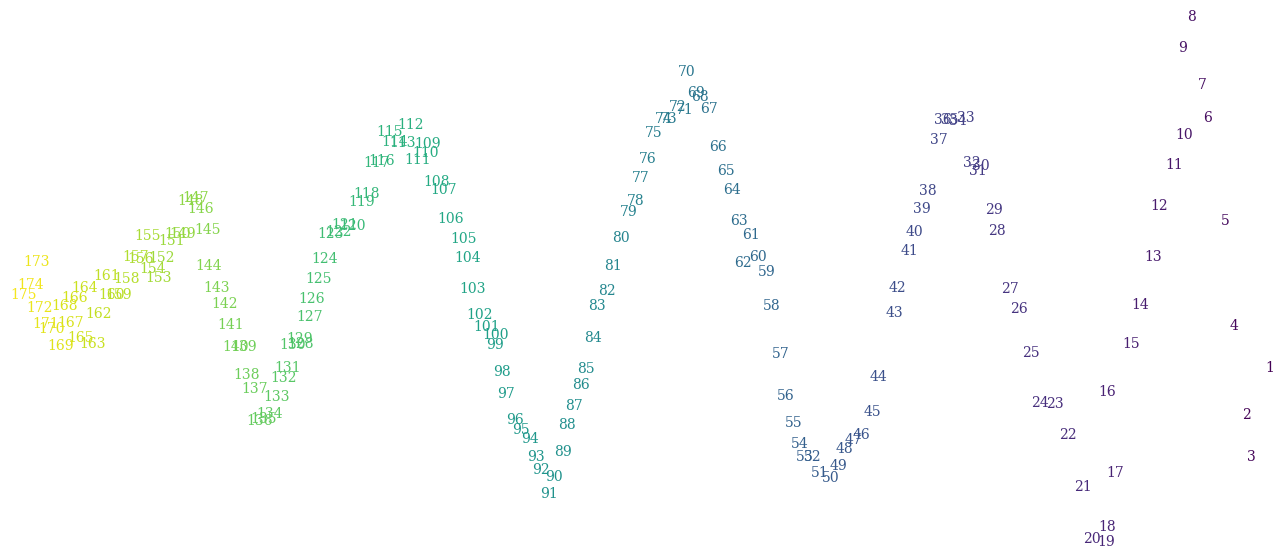

In [57]:
model_name = 'binding'
location = locations[model_name]
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))

mask = data.train_mask & ~torch.isnan(data.y[:, 0])
X_train = data.X[mask]
y_train = data.y[mask]


cmap = "viridis"



# plot the embeddings Z and N are the columns
fig, ax = plt.subplots(1, 1, figsize=(2, 2), sharex=True, sharey=True)
# PC1 vs PC0
def plot_ax0(Z_emb, Z, ax, x_pc=0, y_pc=1, title="Z"):
    Z_emb = Z_emb[1:-1]
    Z = Z[1:-1]
    labels = np.arange(1, len(Z)-1)
    plt.sca(ax)
    # plt.scatter(Z_emb[:, x_pc], Z_emb[:, y_pc], c=Z, cmap=cmap, s=1)
    PlottingContext.scatter_text(labels, Z_emb[:, x_pc], Z_emb[:, y_pc], colors=Z, ax=plt.gca(), fontsize=10)
    plt.xlabel("PC0"); plt.ylabel("PC1"); plt.title(title)

plot_ax0(N_emb, N, ax, title=None)
# PC1 vs PC0
plt.axis('off')
fig.tight_layout(w_pad=0, h_pad=0)
# plt.savefig(f"plots/long-runs/{model_name}/N-emb.pdf")



In [50]:
# from embeddings to output
emb = model.emb[0].detach().cpu().numpy()
pca = PCA(n_components=2)
emb = pca.fit_transform(emb)
emb = torch.from_numpy(pca.inverse_transform(emb))
# generate the input
x = model.embed_input(X, [emb, model.emb[1], model.emb[2]])
# get the output
x = model.readout(model.nonlinear(x))
pred = data.regression_transformer.inverse_transform(x.detach().cpu().numpy())[:, [0]]
# rms 
rms = np.sqrt(np.mean((pred - y.detach().cpu().numpy()) ** 2))
rms

11604.21

/tmp/ipykernel_3504531/937538791.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Binding Energy [scaled]")


Text(0.5, 1.0, 'Z pcs for fixed N=30')

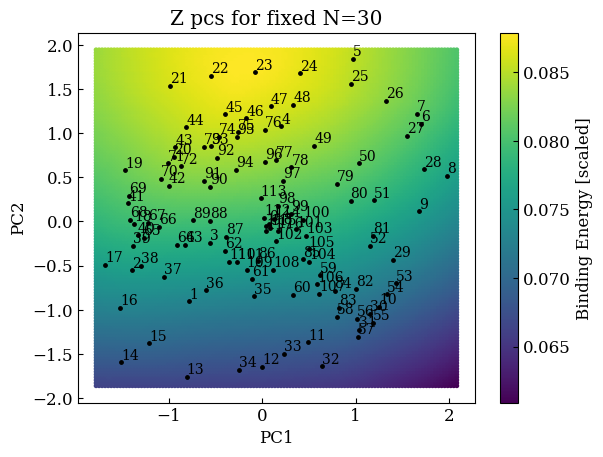

In [58]:
# from embeddings to output
grid_size = 120
emb = model.emb[0].detach().cpu().numpy()
pca = PCA(n_components=3)
emb_ = pca.fit_transform(emb)
emb = torch.from_numpy(pca.inverse_transform(emb_))
idx_0, idx_1 =  1, 2
x_min, x_max = emb_[:, idx_0].min() - .1, emb_[:, idx_0].max() + .1
y_min, y_max = emb_[:, idx_1].min() - .1, emb_[:, idx_1].max() + .1
grid = np.meshgrid(np.linspace(x_min, x_max, grid_size), np.linspace(y_min, y_max, grid_size))
grid = np.stack(grid, axis=-1).reshape(-1, 2)
# preppend dimensions
grid = np.hstack([np.zeros((len(grid), 1))+5, grid])
emb_grid = torch.from_numpy(pca.inverse_transform(grid)).float()
# generate the input of the form [[0, N, 0], [1, N, 0], [2, N, 0], ...]
x = torch.zeros(len(emb_grid), 3, dtype=torch.long)
x[:, 1] = (Neutron:=30)
x[:, 0] = torch.arange(len(emb_grid))
x = model.embed_input(x, [emb_grid, model.emb[1], model.emb[2]])
# get the output
x = model.readout(model.nonlinear(x))
# scatter plot of the output
fig, ax = plt.subplots()
# create color bar object with vmin and vmax
sm = mpl.cm.ScalarMappable(cmap=cmap)
c = sm.to_rgba(x[:, 0].detach().cpu().numpy())
# c =(x[:, 0].detach().cpu().numpy())
sc = plt.scatter(grid[:, idx_0], grid[:, idx_1], c=c, s=6)
plt.colorbar(sm, label="Binding Energy [scaled]")
plt.scatter(emb_[:, idx_0], emb_[:, idx_1], c='k', s=6)
PlottingContext.scatter_text(np.arange(len(emb_)), emb_[:, idx_0], emb_[:, idx_1], ax=ax, fontsize=10)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"Z pcs for fixed N={Neutron}")

# plt.savefig(f"plots/long-runs/{model_name}/pizza-Z-emb{idx_0}-{idx_1}.pdf")

/tmp/ipykernel_3504531/2374379886.py:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Binding Energy [scaled]")


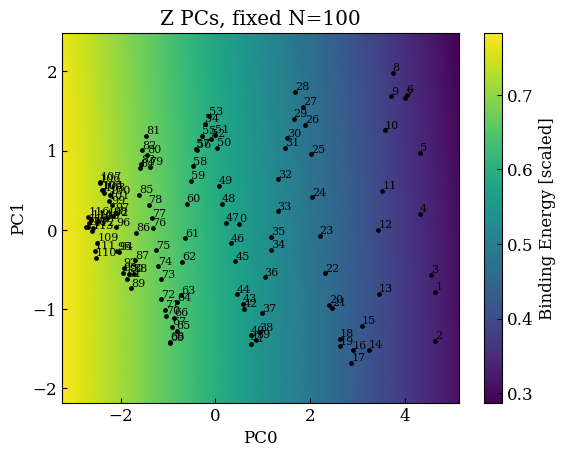

In [70]:
# from embeddings to output
grid_size = 120
emb = model.emb[0].detach().cpu().numpy()
pca = PCA(n_components=2)
emb_ = pca.fit_transform(emb)
emb = torch.from_numpy(pca.inverse_transform(emb_))
idx_0, idx_1 =  0, 1
x_min, x_max = emb_[:, 0].min() - .5, emb_[:, 0].max() + .5
y_min, y_max = emb_[:, 1].min() - .5, emb_[:, 1].max() + .5
grid = np.meshgrid(np.linspace(x_min, x_max, grid_size), np.linspace(y_min, y_max, grid_size))
grid = np.stack(grid, axis=-1).reshape(-1, 2)
emb_grid = torch.from_numpy(pca.inverse_transform(grid)).float()
# generate the input of the form [[0, N, 0], [1, N, 0], [2, N, 0], ...]
x = torch.zeros(len(emb_grid), 3, dtype=torch.long)
x[:, 1] = (Neutron:=100)
x[:, 0] = torch.arange(len(emb_grid))
x = model.embed_input(x, [emb_grid, model.emb[1], model.emb[2]])
# get the output
x = model.readout(model.nonlinear(x))
# scatter plot of the output
fig, ax = plt.subplots()
# create color bar object with vmin and vmax
sm = mpl.cm.ScalarMappable( cmap=cmap)
c = sm.to_rgba(x[:, 0].detach().cpu().numpy())
sc = plt.scatter(grid[:, 0], grid[:, 1], c=c, s=6, rasterized=True)
plt.colorbar(sm, label="Binding Energy [scaled]")
plt.scatter(emb_[:, 0], emb_[:, 1], c='k', s=6, rasterized=True)
PlottingContext.scatter_text(np.arange(len(emb_)), emb_[:, 0], emb_[:, 1], ax=ax, fontsize=8)
plt.xlabel("PC0"); plt.ylabel("PC1")
plt.title(f"Z PCs, fixed N={Neutron}")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
# plt.axis('off')
plt.savefig(f"plots/long-runs/{model_name}/pizza-Z-emb{idx_0}-{idx_1}.pdf")

In [ ]:
from sklearn.linear_model import LinearRegression
def get_ZNy(data, min_included_nucl, task_name, mask_unc):
    X = data.X
    y = data.y
    if task_name=="binding_semf" or task_name=="binding" :
        mask_target = (X[:, 2] == 0)
    X = X[mask_target]
    y = y[mask_target]
    unc = data.binding_unc[~torch.isnan(y_task.view(-1))]
    X = X[~torch.isnan(y_task.view(-1))]
    y = y[~torch.isnan(y_task.view(-1))]
    Z = X[:,0]
    N = X[:,1]
    mask = np.array((Z > min_included_nucl) & (N > min_included_nucl))
    if (task_name=="binding_semf" or task_name=="binding") and mask_unc:
        mask_unc = np.array((unc * (Z + N) < 100))
        mask = (mask & mask_unc)
    # elif task_name=="radius":
    #     mask = (df.unc_r < 0.005).values
    return Z[mask], N[mask], y[mask]
Z, N, y = get_ZNy(data, 9, "binding", True)
A = Z+N
def PC0n(Z, N):
    return (1.e-6 * Z**2 - 0.09) * (N + Z + 2.5 * np.sin(-0.13 * N + 0.2 * Z + 0.25))
def PC2n(Z, N):
    return    0.97**N
PC_stacked = np.column_stack([PC0n(Z, N), PC2n(Z, N)])
#, rounded_PC5, rounded_PC6, rounded_PC7, rounded_PC9
expr_fit = LinearRegression()
expr_fit.fit(PC_stacked, y)
coefs = expr_fit.coef_
inter = expr_fit.intercept_
# Get the coefficients (A) and the intercept (b)
y_pysr_pred = expr_fit.predict(PC_stacked)
physics_binding_terms = {func: getattr(Physics, func)(Z, N) for func in ['SEMF']}
y_semf_pred = physics_binding_terms['SEMF']*A
print('PySR RMS:', np.sqrt(np.mean((np.array(y) - y_pysr_pred)**2)))
print('Fake SEMF RMS:', np.sqrt(np.mean((np.array(y.T - y_semf_pred))**2)))